[<img src="https://gitlab.irit.fr/toc/etu-n7/controle-optimal/-/raw/master/ressources/Logo-toulouse-inp-N7.png" alt="N7" height="100"/>](https://gitlab.irit.fr/toc/etu-n7/controle-optimal)

TP évalué : Contrôle optimal

Date : 2024-2025

**ATTENTION** : Vous aurez besoin des fichiers utils.jl et space.jl pour faire fonctionner ce TP. Ils sont disponibles dans le dépôt GitLab du cours.

<div style="width:90%;
            margin:10px;
            padding:8px;
            background-color:#FAA299;
            border:2px solid #BF381B;
            border-radius:20px;
            font-weight:bold;
            font-size:1em;"> <!-- il faut laisser une ligne vide après celle-ci -->

* Nom : BAILLIET
* Prénom : Nicolas
</div>

# Transfert orbital

Ce sujet (ou TP-projet) est à rendre (voir la date sur moodle et les modalités du rendu) et sera évalué pour faire partie de la note finale de la matière Contrôle Optimal.

<div style="width:90%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:20px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
Transfert orbital à temps minimal
</div>


On considère le problème du transfert d'un satellite d'une orbite initiale à l'orbite géostationnaire à temps minimal. Ce problème s'écrit comme un problème de contrôle optimal sous la forme

$$
\left\lbrace
\begin{array}{l}
    \min J(x, u, t_f) = t_f \\[1.0em]
    \ \ \dot{x}_{1}(t) = ~ x_{3}(t)  \\[0.5em]
    \ \ \dot{x}_{2}(t) = ~ x_{4}(t)  \\[0.5em]
    \ \ \dot{x}_{3}(t) =  -\dfrac{\mu\, x_{1}(t)}{r^{3}(x(t))} + u_{1}(t)  \\[1em]
    \ \ \dot{x}_{4}(t) =  -\dfrac{\mu\, x_{2}(t)}{r^{3}(x(t))} + u_{2}(t), ~~ ||u(t)|| \leq \gamma_\mathrm{max}, ~~ t \in [0,t_f] ~~ \text{p.p.}, ~~ u(t) = (u_1(t),u_2(t)),  \\[1.5em]
    \ \ x_{1}(0)=x_{0,1}, ~~ x_{2}(0)=x_{0,2}, ~~ x_{3}(0)=x_{0,3}, ~~ x_{4}(0)=x_{0,4}, \\[1em]
    \ \ r(x(t_f)) = r_{f}, ~~ x_{3}(t_f)=-\sqrt{\dfrac{\mu}{r_{f}^{3}}}x_{2}(t_f), ~~ x_{4}           (t_f)= \sqrt{\dfrac{\mu}{r_{f}^{3}}}x_{1}(t_f), \\
\end{array}
\right.
$$

avec $r(x)=\sqrt{x_{1}^{2}+x_{2}^{2}}$.
Les unités choisies sont le kilomètre pour les distances et l'heure pour les  temps. On donne les paramètres suivants :
 
$$
\mu=5.1658620912 \times 10^{12} \ \mathrm{km}^{3}.\mathrm{h}^{-2}, \quad r_{f} = 42165 \ \mathrm{km}.
$$

Le paramètre $\gamma_\mathrm{max}$ dépend de la poussée maximale $F_\mathrm{max}$ suivant la relation :

$$
\gamma_\mathrm{max} = \frac{F_\mathrm{max}\times 3600^2}{m} 
$$

où m est la masse du satellite qu'on fixe à $m=2000\ \mathrm{kg}$.

### Résolution via du tir simple indirect

In [20]:
using DifferentialEquations # ou OrdinaryDiffEq
using NLsolve
using ForwardDiff
using Plots
using LinearAlgebra
include("utils.jl"); # fonctions utilitaires

In [21]:
# Les constantes du pb
x0     = [-42272.67, 0, 0, -5796.72] # état initial
μ      = 5.1658620912*1e12
rf     = 42165
F_max  = 100
γ_max  = F_max*3600^2/(2000*10^3)
t0     = 0
rf3    = rf^3
α      = sqrt(μ/rf3);

✏️ **_Question 1:_**
    
1. Donner le pseudo-hamiltonien associé au problème de contrôle optimal.
2. Donner le pseudo système hamiltonien
$$
    \vec{H}(x, p, u) = \left(\frac{\partial H}{\partial p}(x, p, u), 
    -\frac{\partial H}{\partial x}(x, p, u) \right).
$$
3. Calculer le contrôle maximisant. On supposera que $(p_3, p_4)\neq (0,0)$.

**Réponse** 

<div style="width:90%;
            margin:10px;
            padding:20px;
            background-color:#111111;
            border:2px solid #063970;
            border-radius:20px;
            font-weight:bold;
            font-size:1em;"> <!-- il faut laisser une ligne vide après celle-ci -->

**1°)**
$$
    H(x,u,p) = p_{1}x_{3} + p_{2}x_{4} + p_{3}(-\frac{\mu x_{1}}{r^{3}} + u_{1}) + p_{4}(-\frac{\mu x_{2}}{r^{3}} + u_{2})
$$

**2°)**
$$
    \vec{H}(x, p, u) = (\dot x, \dot p) = \left(\frac{\partial H}{\partial p}(x, p, u), -\frac{\partial H}{\partial x}(x, p, u) \right) \\

    \frac{\partial H}{\partial p}(x,p,u) = 
    \begin{pmatrix}
        x_{3} \\
        x_{4} \\
        -\frac{\mu x_{1}}{r^{3}} + u_{1} \\
        -\frac{\mu x_{2}}{r^{3}} + u_{2} \\
    \end{pmatrix} \\

    -\frac{\partial H}{\partial x}(x,p,u) = 
    \begin{pmatrix}
        \mu p_{3}(\frac{1}{r^{3}} - \frac{3x_{1}^{2}}{r^{5}}) - 3\mu p_{4}\frac{x_{1}x_{2}}{r^{5}} \\   
        \mu p_{4}(\frac{1}{r^{3}} - \frac{3x_{2}^{2}}{r^{5}}) - 3\mu p_{3}\frac{x_{1}x_{2}}{r^{5}} \\          
        -p_{1} \\
        -p_{2}
    \end{pmatrix}

$$

**3)**
$$
    H(x,p,u) = H_{0}(x,p) + u_{1}p_{3} + u_{2}p_{4} \\
    H(x,p,u) = H_{0}(x,p) + < u | \Phi (x,p) > \text{ où } 
    \Phi(x,p) = 
    \begin{pmatrix}
        p_{3} \\
        p_{4}
    \end{pmatrix} \\

    \text{max}_{||u|| \leq \gamma_{max}} = \gamma_{max} \frac{\Phi(x,p)}{||\Phi(x,u)||}
$$
</div>

✏️ **_Question 2:_** Compléter le code suivant contenant le pseudo-hamiltonien, le pseudo système hamiltonien et le contrôle maximisant.

In [22]:
#####
##### A COMPLETER

function r(x)
    return sqrt(x[1]^2 + x[2]^2)
end

# pseudo-Hamiltonien
function H(x, p, u)
    # H(x, p, u) = < p | f(x,u) >
    h = p[1]*x[3] + p[2]*x[4] + p[3]*(u[1] - μ*x[1]/(r(x)^3)) + p[4]*(u[2] - μ*x[2]/(r(x)^3))
    return h
end

# pseudo système hamiltonien
function Hv(x, p, u)
    n     = size(x, 1)
    # ̇x = ∂H/∂p
    dx    = zeros(eltype(x), n)
    dx[1] = x[3]
    dx[2] = x[4]
    dx[3] = -μ*x[1]/(r(x)^3) + u[1]
    dx[4] = -μ*x[2]/(r(x)^3) + u[2]
    # ̇p = -∂H/∂x
    dp    = zeros(eltype(x), n)
    dp[1] = μ*p[3]*((1/(r(x)^3)) - ((3*x[1]*x[1])/(r(x)^5))) - 3*μ*p[4]*(x[1]*x[2]/(r(x)^5))
    dp[2] = μ*p[4]*((1/(r(x)^3)) - ((3*x[2]*x[2])/(r(x)^5))) - 3*μ*p[3]*(x[1]*x[2]/(r(x)^5))
    dp[3] = -p[1]
    dp[4] = -p[2]

    return dx, dp
end

# Contrôle maximisant
function control(p)
    u    = zeros(eltype(p),2)
    u[1] = γ_max * p[3] / sqrt(p[3]*p[3] + p[4]*p[4])
    u[2] = γ_max * p[4] / sqrt(p[3]*p[3] + p[4]*p[4])
    return u
end

#####
##### FIN A COMPLETER

# flot hamiltonien pour le calcul des extrémales
f = Flow((x, p) -> Hv(x, p, control(p)));

On note 
$
    \alpha := \sqrt{\frac{\mu}{r_f^3}}.
$
La condition terminale peut se mettre sous la forme $c(x(t_f)) = 0$, avec $c \colon \mathbb{R}^4 \to \mathbb{R}^3$.

✏️ **_Question 3:_** Donner l'expression de $c(x)$.

**Réponse** 

<div style="width:90%;
            margin:10px;
            padding:20px;
            background-color:#111111;
            border:2px solid #063970;
            border-radius:20px;
            font-weight:bold;
            font-size:1em;"> <!-- il faut laisser une ligne vide après celle-ci -->

$$
    c(x) = (r(x) - r_{f}, x_{3} + \alpha x_{2}, x_{4} - \alpha x_{1})
$$
</div>

Le temps final étant libre, on a la condition au temps final 

$$
    H(x(t_f), p(t_f), u(t_f)) = -p^0 = 1. \quad \text{(on se place dans le cas normal)}
$$

De plus, la condition de transversalité 

$$
p(t_f) = c'(x(t_f))^T \lambda, ~~ \lambda \in \mathbb{R}^3,
$$

conduit à la relation suivante (où $\lambda$ n'apparaît plus)

$$
\Phi(x(t_f), p(t_f)) := x_2(t_f) \Big( p_1(t_f) + \alpha\, p_4(t_f) \Big) - x_1(t_f) \Big( p_2(t_f) - \alpha\, p_3(t_f) \Big) = 0.
$$

En considérant la condition aux limites, la condition finale sur le pseudo-hamiltonien et la condition de transversalité, la fonction de tir simple est donnée par 

\begin{equation*}
    \begin{array}{rlll}
        S \colon    & \mathbb{R}^5          & \longrightarrow   & \mathbb{R}^5 \\
        & (p_0, t_f)      & \longmapsto       &
        S(p_0, t_f) := \begin{pmatrix}
            c(x(t_f, x_0, p_0)) \\[0.5em]
            \Phi(z(t_f, x_0, p_0)) \\[0.5em]
            H(z(t_f, x_0, p_0), u(z(t_f, x_0, p_0))) - 1
        \end{pmatrix}
    \end{array}
\end{equation*}

où $z(t_f, x_0, p_0)$ est la solution au temps $t_f$ du pseudo système hamiltonien bouclé par
le contrôle maximisant, partant au temps $t_0=0$ du point $(x_0, p_0)$. On rappelle que l'on note
$z=(x, p)$.

✏️ **_Question 4:_** Compléter le code suivant de la fonction de tir.

In [23]:
#####
##### A COMPLETER

# Fonction de tir
function shoot(p0, tf)
    x_tf, p_tf = f(t0, x0, p0, tf)

    s = zeros(eltype(p0), 5)

    # c(x(tf)) 
    r_tf = sqrt(x_tf[1]^2 + x_tf[2]^2)
    s[1] = r_tf - rf 
    s[2] = x_tf[3] + α*x_tf[2]
    s[3] = x_tf[4] - α*x_tf[1]

    # Condition de transversalité
    s[4] = x_tf[2]*(p_tf[1] + α*p_tf[4]) - x_tf[1]*(p_tf[2] - α*p_tf[3])

    # H(z(tf,x0,p0),u(z(tf,x0,p0))) + p°
    u_tf = control(p_tf)
    H_tf = H(x_tf, p_tf, u_tf)
    s[5] = H_tf - 1 # p° = -1
    
    return s
end

shoot (generic function with 1 method)

✏️ **_Question 5:_** Expliquer simplement ce que fait le code suivant.

**Réponse**

<div style="width:90%;
            margin:10px;
            padding:20px;
            background-color:#111111;
            border:2px solid #063970;
            border-radius:20px;
            font-weight:bold;
            font-size:1em;"> <!-- il faut laisser une ligne vide après celle-ci -->

Le code ci-dessous construit la fonction de tir et sa jacobienne, puis résout l'équation $ S(p_{0}, t_{f}) = 0 $ par une méthode de Newton de la fonction NLSolve. 
Cela permet de trouver les condtitions initiales du co-vecteurs et le temps final satisfaisant le problème optimal.
</div>

In [24]:
# Itéré initial
y_guess = [1.0323e-4, 4.915e-5, 3.568e-4, -1.554e-4, 13.4]   # pour F_max = 100N

# Jacobienne de la fonction de tir
foo(y)  = shoot(y[1:4], y[5])
jfoo(y) = ForwardDiff.jacobian(foo, y)

# Résolution de shoot(p0, tf) = 0
nl_sol = nlsolve(foo, jfoo, y_guess; xtol=1e-8, method=:trust_region, show_trace=true);

# On récupère la solution si convergence
if converged(nl_sol)
    p0_sol_100 = nl_sol.zero[1:4]
    tf_sol_100 = nl_sol.zero[5]
    println("\nFinal solution:\n", nl_sol.zero)
else
    error("Not converged")
end

Iter     f(x) inf-norm    Step 2-norm 
------   --------------   --------------
     0     4.208247e+02              NaN
     1     3.419791e+00     3.507495e-03
     2     8.493478e-02     3.222915e-04
     3     4.217272e-07     3.247983e-06
     4     1.164153e-10     2.964989e-10

Final solution:
[0.00010323118913618905, 4.892642781236179e-5, 0.00035679672939065496, -0.00015536138862859997, 13.403181957149327]


In [25]:
# Fonction d'affichage d'une solution
function plot_solution(p0, tf)

    # On trace l'orbite de départ et d'arrivée
    gr(dpi=300, size=(500,400), thickness_scaling=1)
    r0        = norm(x0[1:2])
    v0        = norm(x0[3:4])
    a         = 1.0/(2.0/r0-v0*v0/μ)
    t1        = r0*v0*v0/μ - 1.0;
    t2        = (x0[1:2]'*x0[3:4])/sqrt(a*μ);
    e_ellipse = norm([t1 t2])
    p_orb     = a*(1-e_ellipse^2);
    n_theta   = 101
    Theta     = range(0, stop=2*pi, length=n_theta)
    X1_orb_init = zeros(n_theta)
    X2_orb_init = zeros(n_theta)
    X1_orb_arr  = zeros(n_theta)
    X2_orb_arr  = zeros(n_theta)

    # Orbite initiale
    for  i in 1:n_theta
        theta = Theta[i]
        r_orb = p_orb/(1+e_ellipse*cos(theta));
        X1_orb_init[i] = r_orb*cos(theta);
        X2_orb_init[i] = r_orb*sin(theta);
    end

    # Orbite d'arrivée
    for  i in 1:n_theta
        theta = Theta[i]
        X1_orb_arr[i] = rf*cos(theta) ;
        X2_orb_arr[i] = rf*sin(theta);
    end;

    # Calcul de la trajectoire
    ode_sol  = f((t0, tf), x0, p0)
    t  = ode_sol.t
    x1 = [ode_sol[1, j] for j in 1:size(t, 1) ]
    x2 = [ode_sol[2, j] for j in 1:size(t, 1) ]
    u  = zeros(2, length(t))

    for j in 1:size(t, 1)
        u[:,j] = control(ode_sol[5:8, j])
    end

    px = plot(x1, x2, color=:red, legend=:best, label="Trajectoire",
        border=:none, size = (800,400), aspect_ratio=:equal)
    plot!(px, X1_orb_init, X2_orb_init, color=:green, label="Orbite initiale")
    plot!(px, X1_orb_arr, X2_orb_arr, color=:blue, label="Orbite d'arrivée")
    plot!(px, [x0[1]], [x0[2]], seriestype=:scatter, color=:green, markersize = 5, label="Départ")
    xf = ode_sol[1:2, end]
    plot!(px, [xf[1]], [xf[2]], seriestype=:scatter, color=:red, markersize = 5, label="Arrivée")
    plot!(px, [0.0], [0.0], color = :blue, seriestype=:scatter, markersize = 25, label="Terre")

    pu1 = plot(t, u[1,:], color=:red, label="u₁(t)", legend=:best)
    pu2 = plot(t, u[2,:], color=:red, label="u₂(t)", legend=:best)

    display(plot(pu1, pu2, layout = (1,2), size = (800,400)))
    display(px)
    
end;

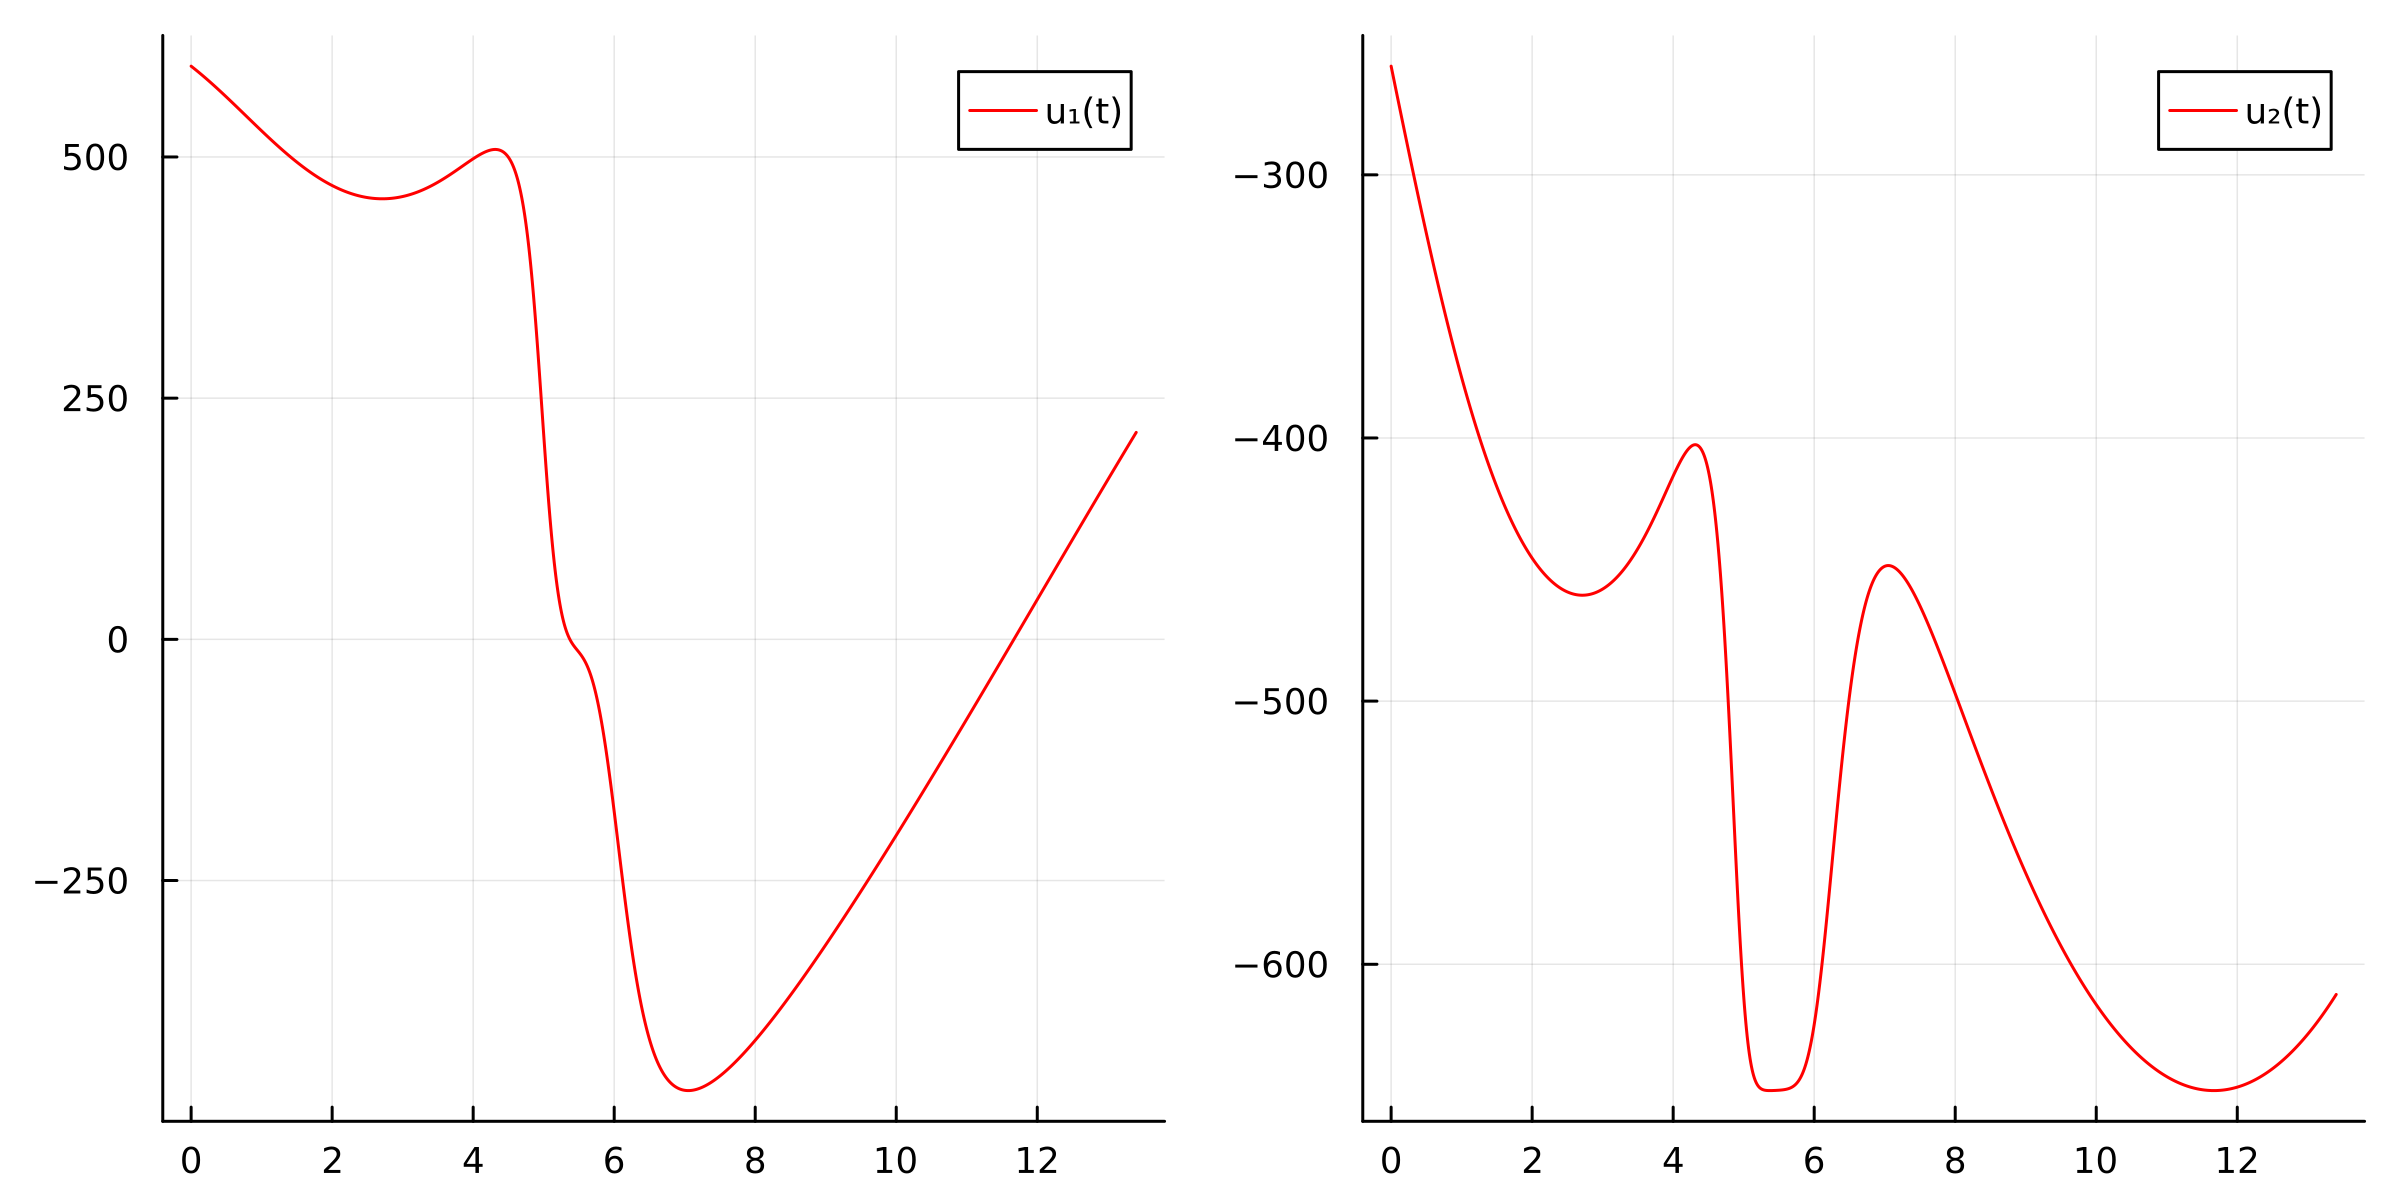

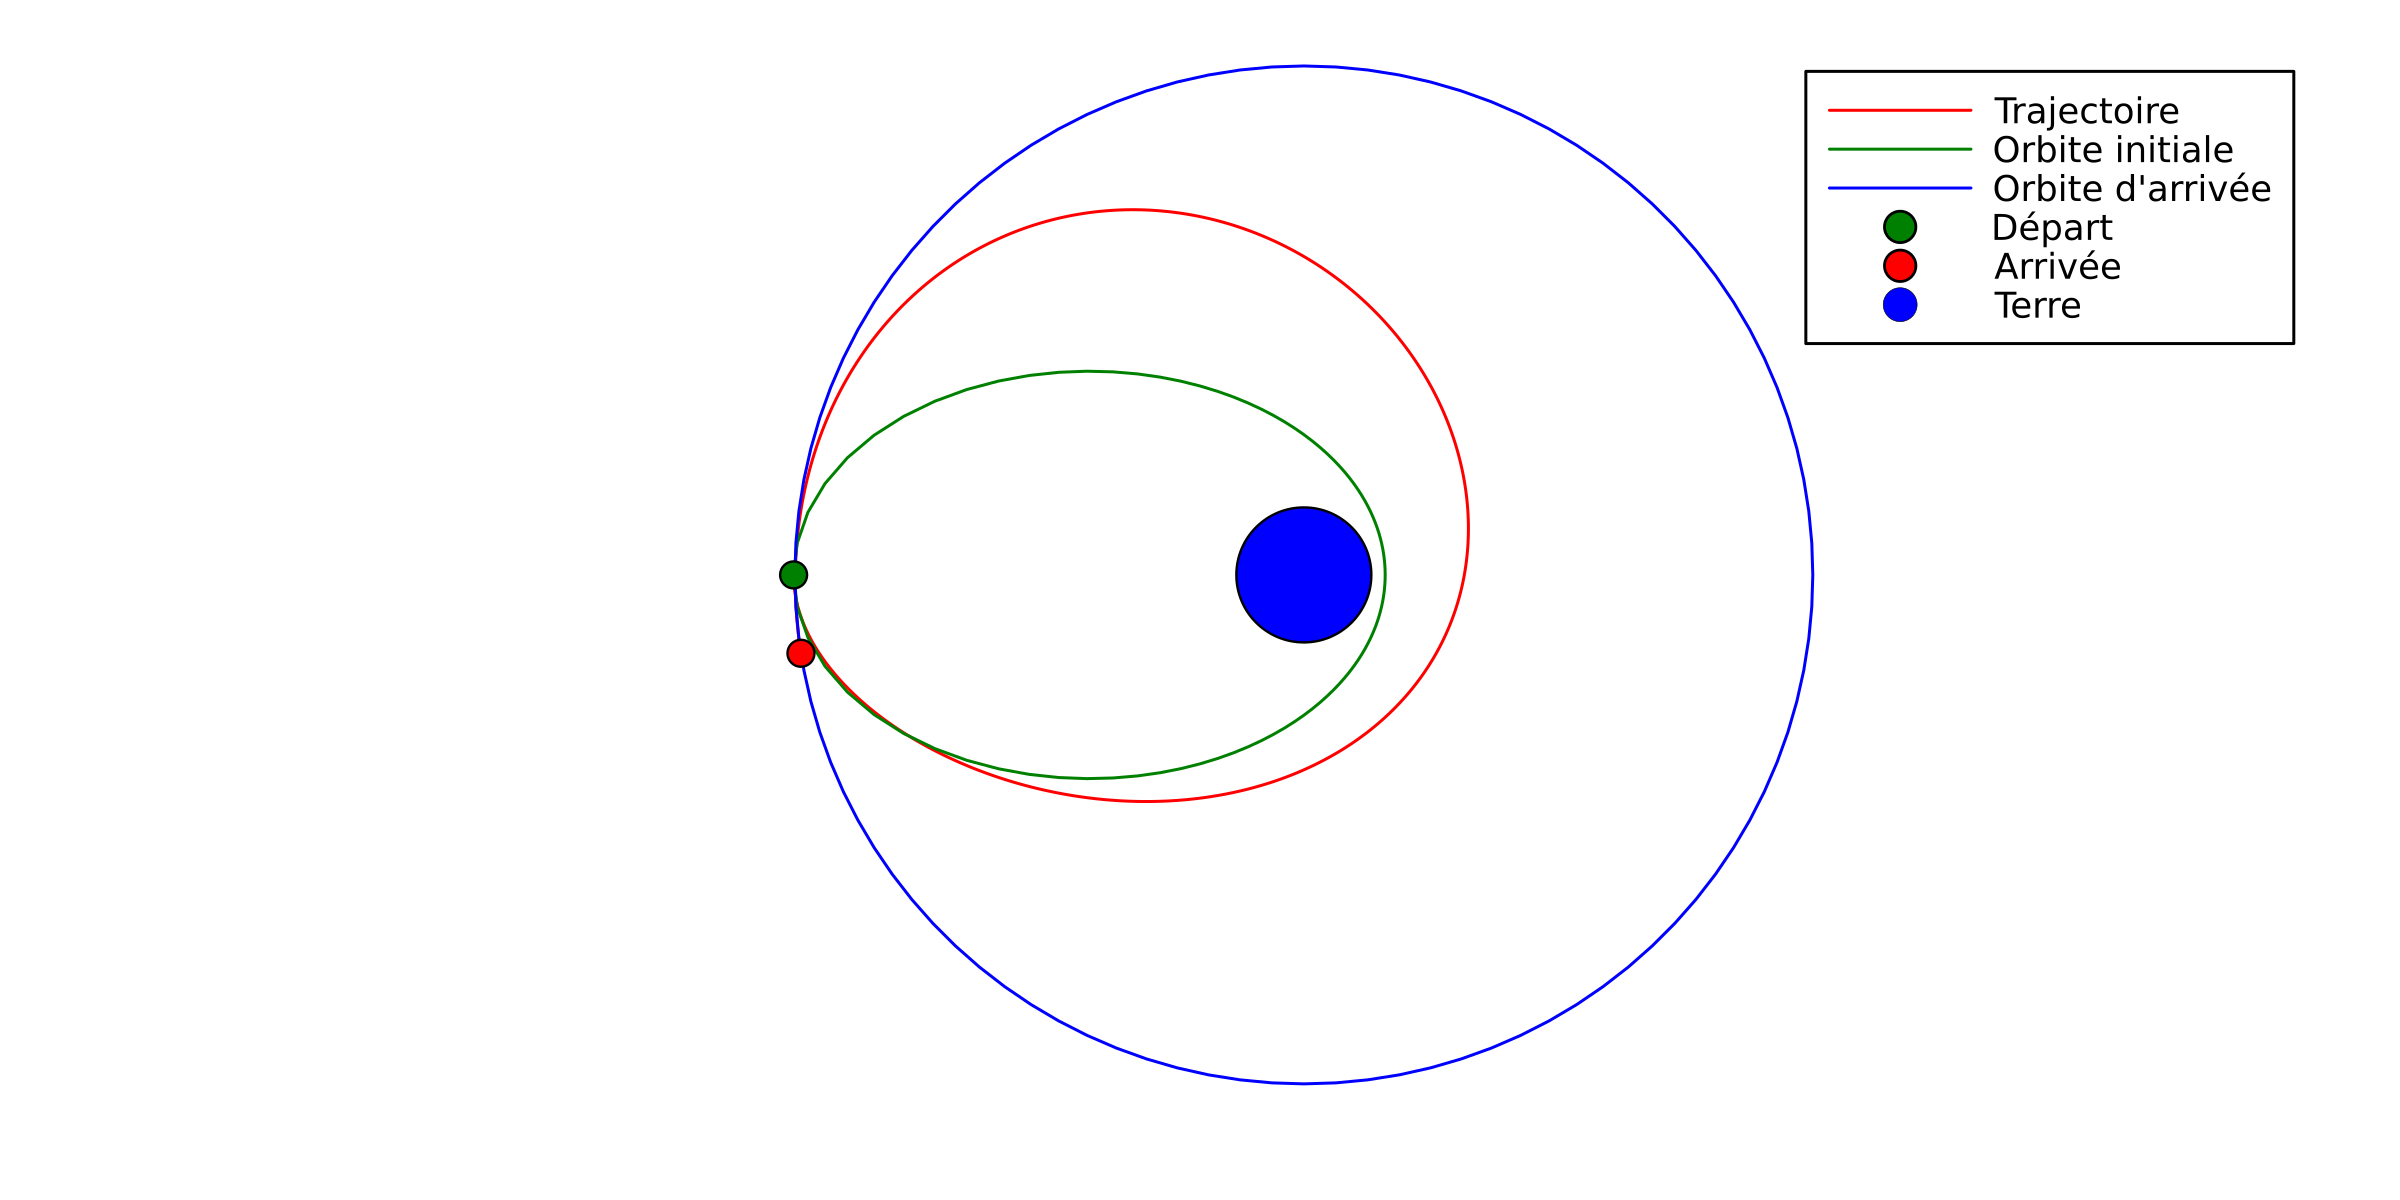

In [26]:
# On affiche la solution pour Fmax = 100
plot_solution(p0_sol_100, tf_sol_100)

✏️ **_Question 6:_** Que vaut le temps final $t_f$ (à 5 digits près) ? Combien de révolutions complètes autour de la Terre a réalisé le satellite.

**Réponse**

<div style="width:90%;
            margin:10px;
            padding:20px;
            background-color:#111111;
            border:2px solid #063970;
            border-radius:20px;
            font-weight:bold;
            font-size:1em;"> <!-- il faut laisser une ligne vide après celle-ci -->

Après résolution de l'équation $S(p_{0}, t_{f}) = 0$, on obtient $t_{f} = 13,4 $ h et une seule révolution complète autour de la Terre.
</div>

### Etude du temps de transfert en fonction de la poussée maximale

✏️ **_Question 7:_** 

* A l'aide de ce que vous avez fait précédemment, déterminer $t_f$ (attention, penser à bien itinialiser la
méthode de tir) pour
    
$$
    F_\mathrm{max} \in \{100, 90, 80, 70, 60, 50, 40, 30, 20 \}.
$$
    
* Tracer ensuite $t_f$ en fonction de $F_\mathrm{max}$ et commenter le résultat.

In [27]:
# Les différentes valeurs de poussées
F_max_span = range(100, stop=20, length=11);
γ_max_span = [F_max_span[j]*3600^2/(2000*10^3) for j in 1:size(F_max_span,1)];

In [28]:
# Solution calculée précédemment
y_guess = [p0_sol_100; [tf_sol_100]]

# Pour le stockage des solutions
tf_sols = zeros(length(γ_max_span))     # vecteur des temps de transfert
p0_sols = zeros(4, length(γ_max_span))  # matrice des co-états initiaux

#####
##### A COMPLETER

for i in 1:length(γ_max_span)
    
    # On met à jour y_max pour pouvoir utiliser sa nouvelle valeur lors de l'appel des fonctions à venir
    global γ_max = γ_max_span[i] 

    f = Flow((x, p) -> Hv(x, p, control(p)));
    foo(y)  = shoot(y[1:4], y[5])
    jfoo(y) = ForwardDiff.jacobian(foo, y)
    if i == 1
        y_guess_span = y_guess
    else 
        y_guess_span = [p0_sols[:, i-1]; tf_sols[i-1]]
    end
    sol = nlsolve(foo, jfoo, y_guess_span; xtol=1e-8, method=:trust_region);

    if converged(sol)
        p0_sols[:, i] = sol.zero[1:4]
        tf_sols[i]    = sol.zero[5]
        println("F_max = $(F_max_span[i])N : tf = $(tf_sols[i]) h")
    else
        println("Not converged for F_max = $(F_max_span[i])N")
        p0_sols[:, i] .= NaN
        tf_sols[i] = NaN
    end

end

F_max = 100.0N : tf = 13.403181957149327 h
F_max = 92.0N : tf = 13.842412694293053 h
F_max = 84.0N : tf = 14.388112730599111 h
F_max = 76.0N : tf = 15.168652689912877 h
F_max = 68.0N : tf = 16.787507855054436 h
F_max = 60.0N : tf = 19.548303893941153 h
F_max = 52.0N : tf = 22.741836800576575 h
F_max = 44.0N : tf = 28.224679830201502 h
F_max = 36.0N : tf = 32.497057746200326 h
F_max = 28.0N : tf = 42.60856002393229 h
F_max = 20.0N : tf = 59.85516689032165 h


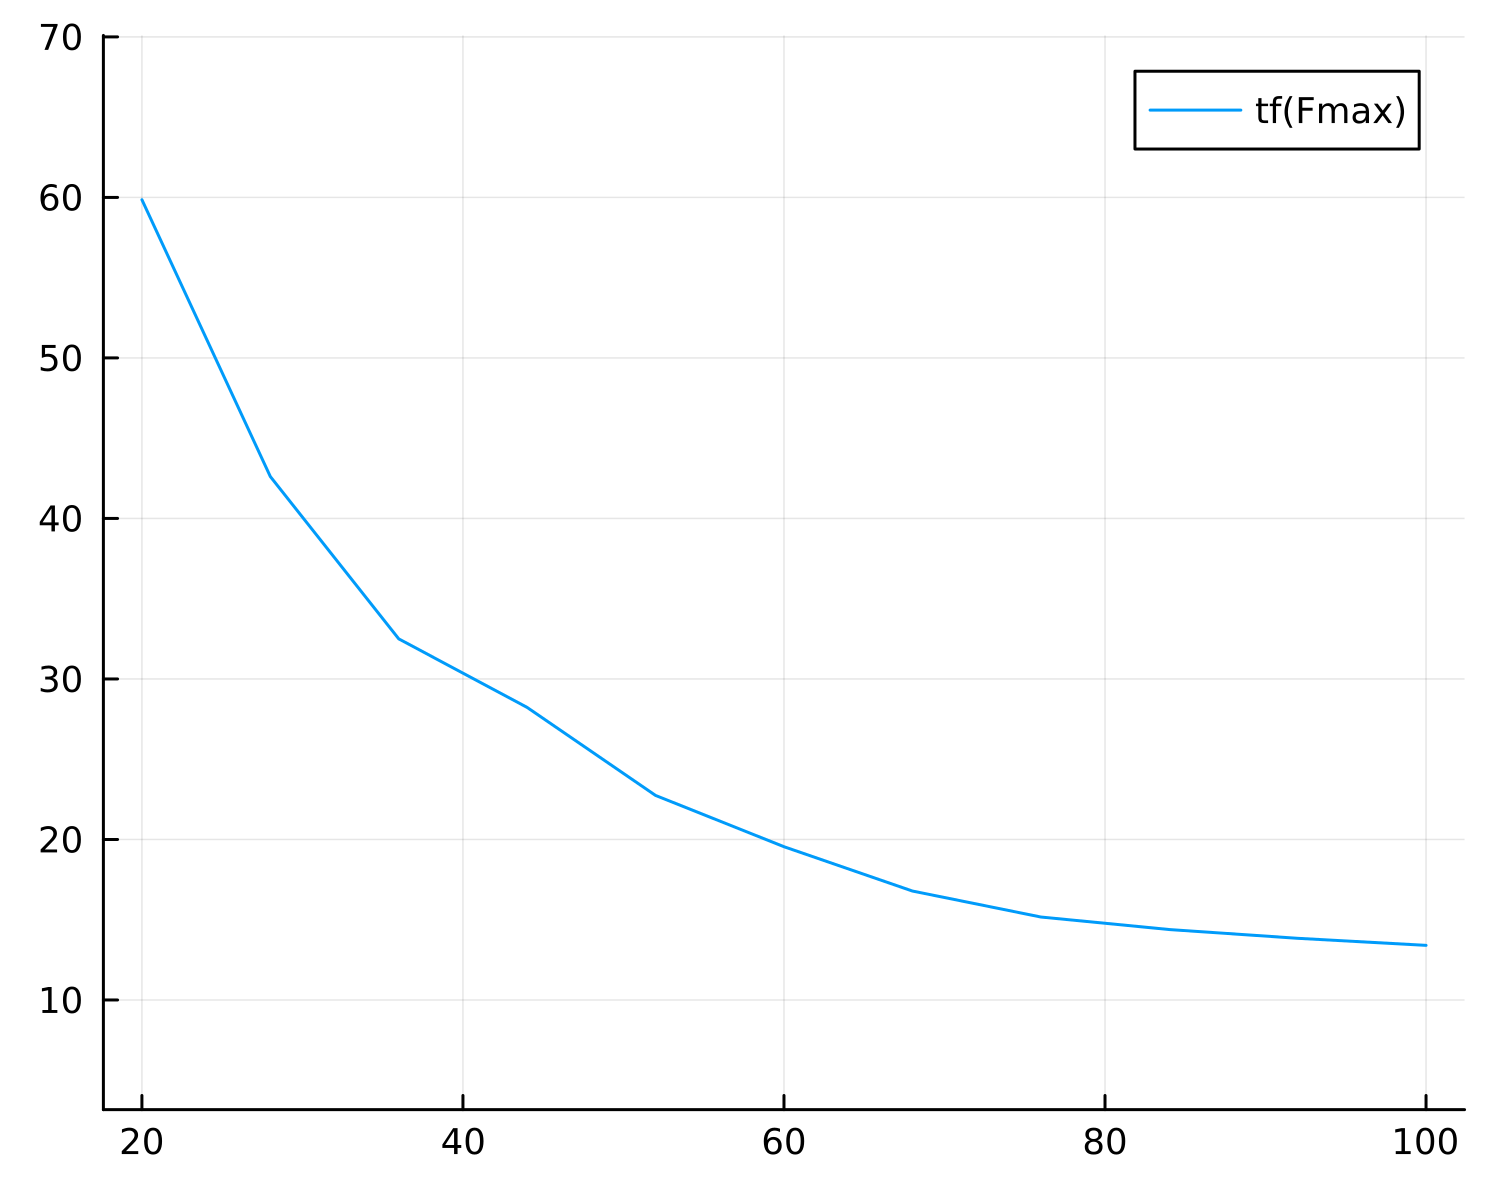

In [29]:
# Affichage de tf en fonction de la poussée maximale
plot(F_max_span, tf_sols, aspect_ratio=:equal, legend=:best, label="tf(Fmax)")

**Réponse** (double cliquer pour modifier le texte et donner votre commentaire)

<div style="width:90%;
            margin:10px;
            padding:20px;
            background-color:#111111;
            border:2px solid #063970;
            border-radius:20px;
            font-weight:bold;
            font-size:1em;"> <!-- il faut laisser une ligne vide après celle-ci -->

On constate que $t_{f}$ en fonction de $F_{max}$ suit une décroissance exponentielle. De ce fait, si nous limitons grandement la force de poussée, le temps $t_{f}$ pour atteindre l'orbite cible peut devenir trop long...
Cependant une trop grande force peut minimiser ce temps certe, mais être trop coûteux en ressource. 
Il est donc préferable de choisir un compromis, ici 80 N semble être le plus intéressant en pratique pour minimiser le temps $t_{f}$.
</div>

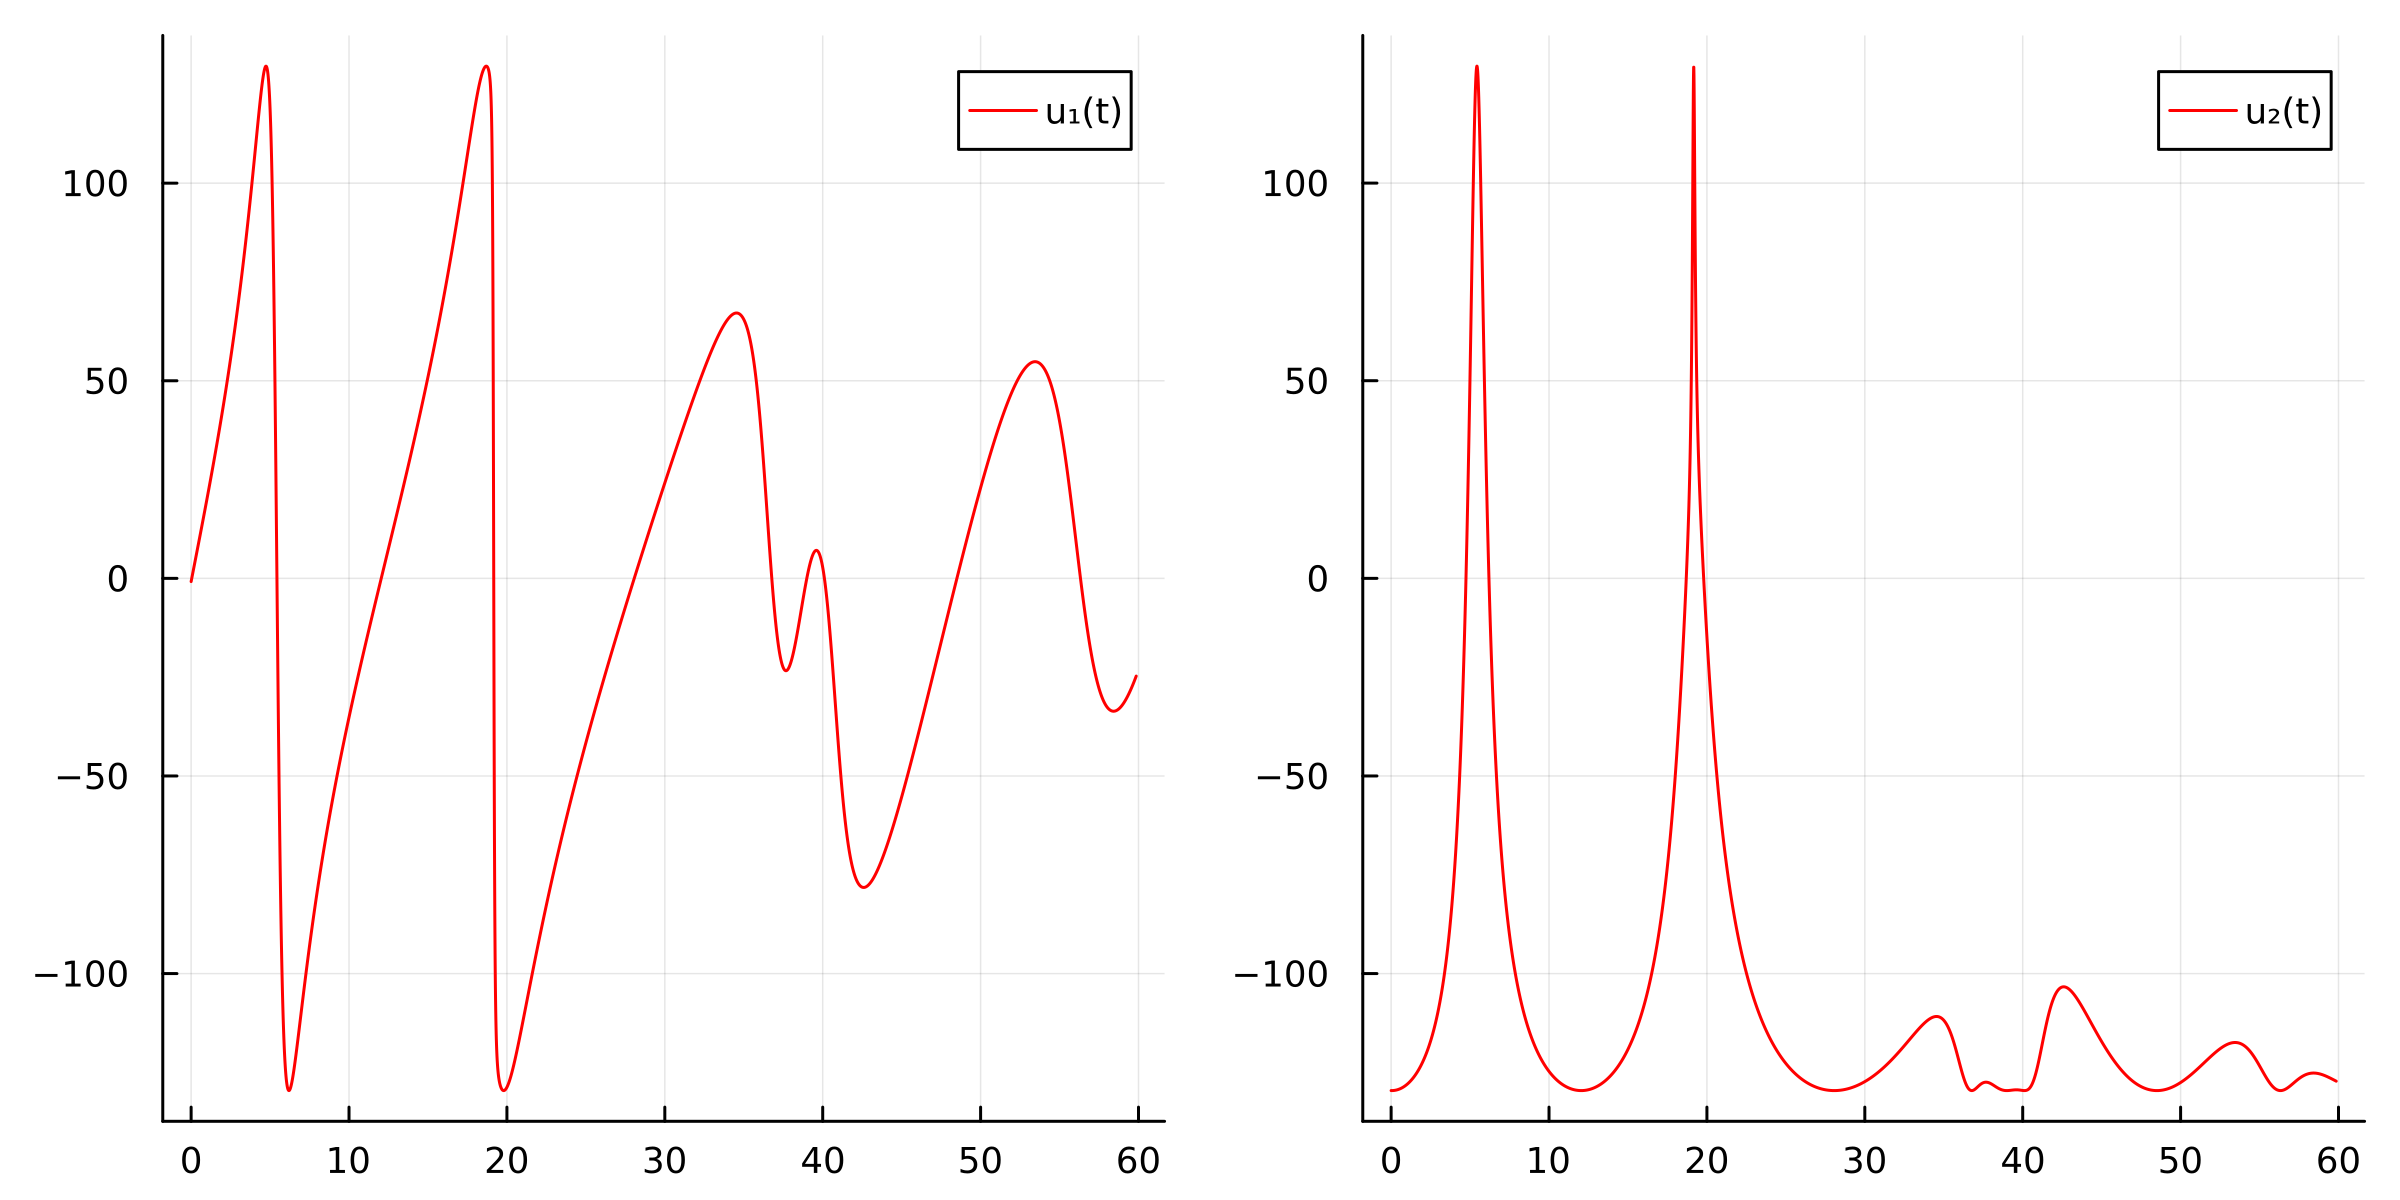

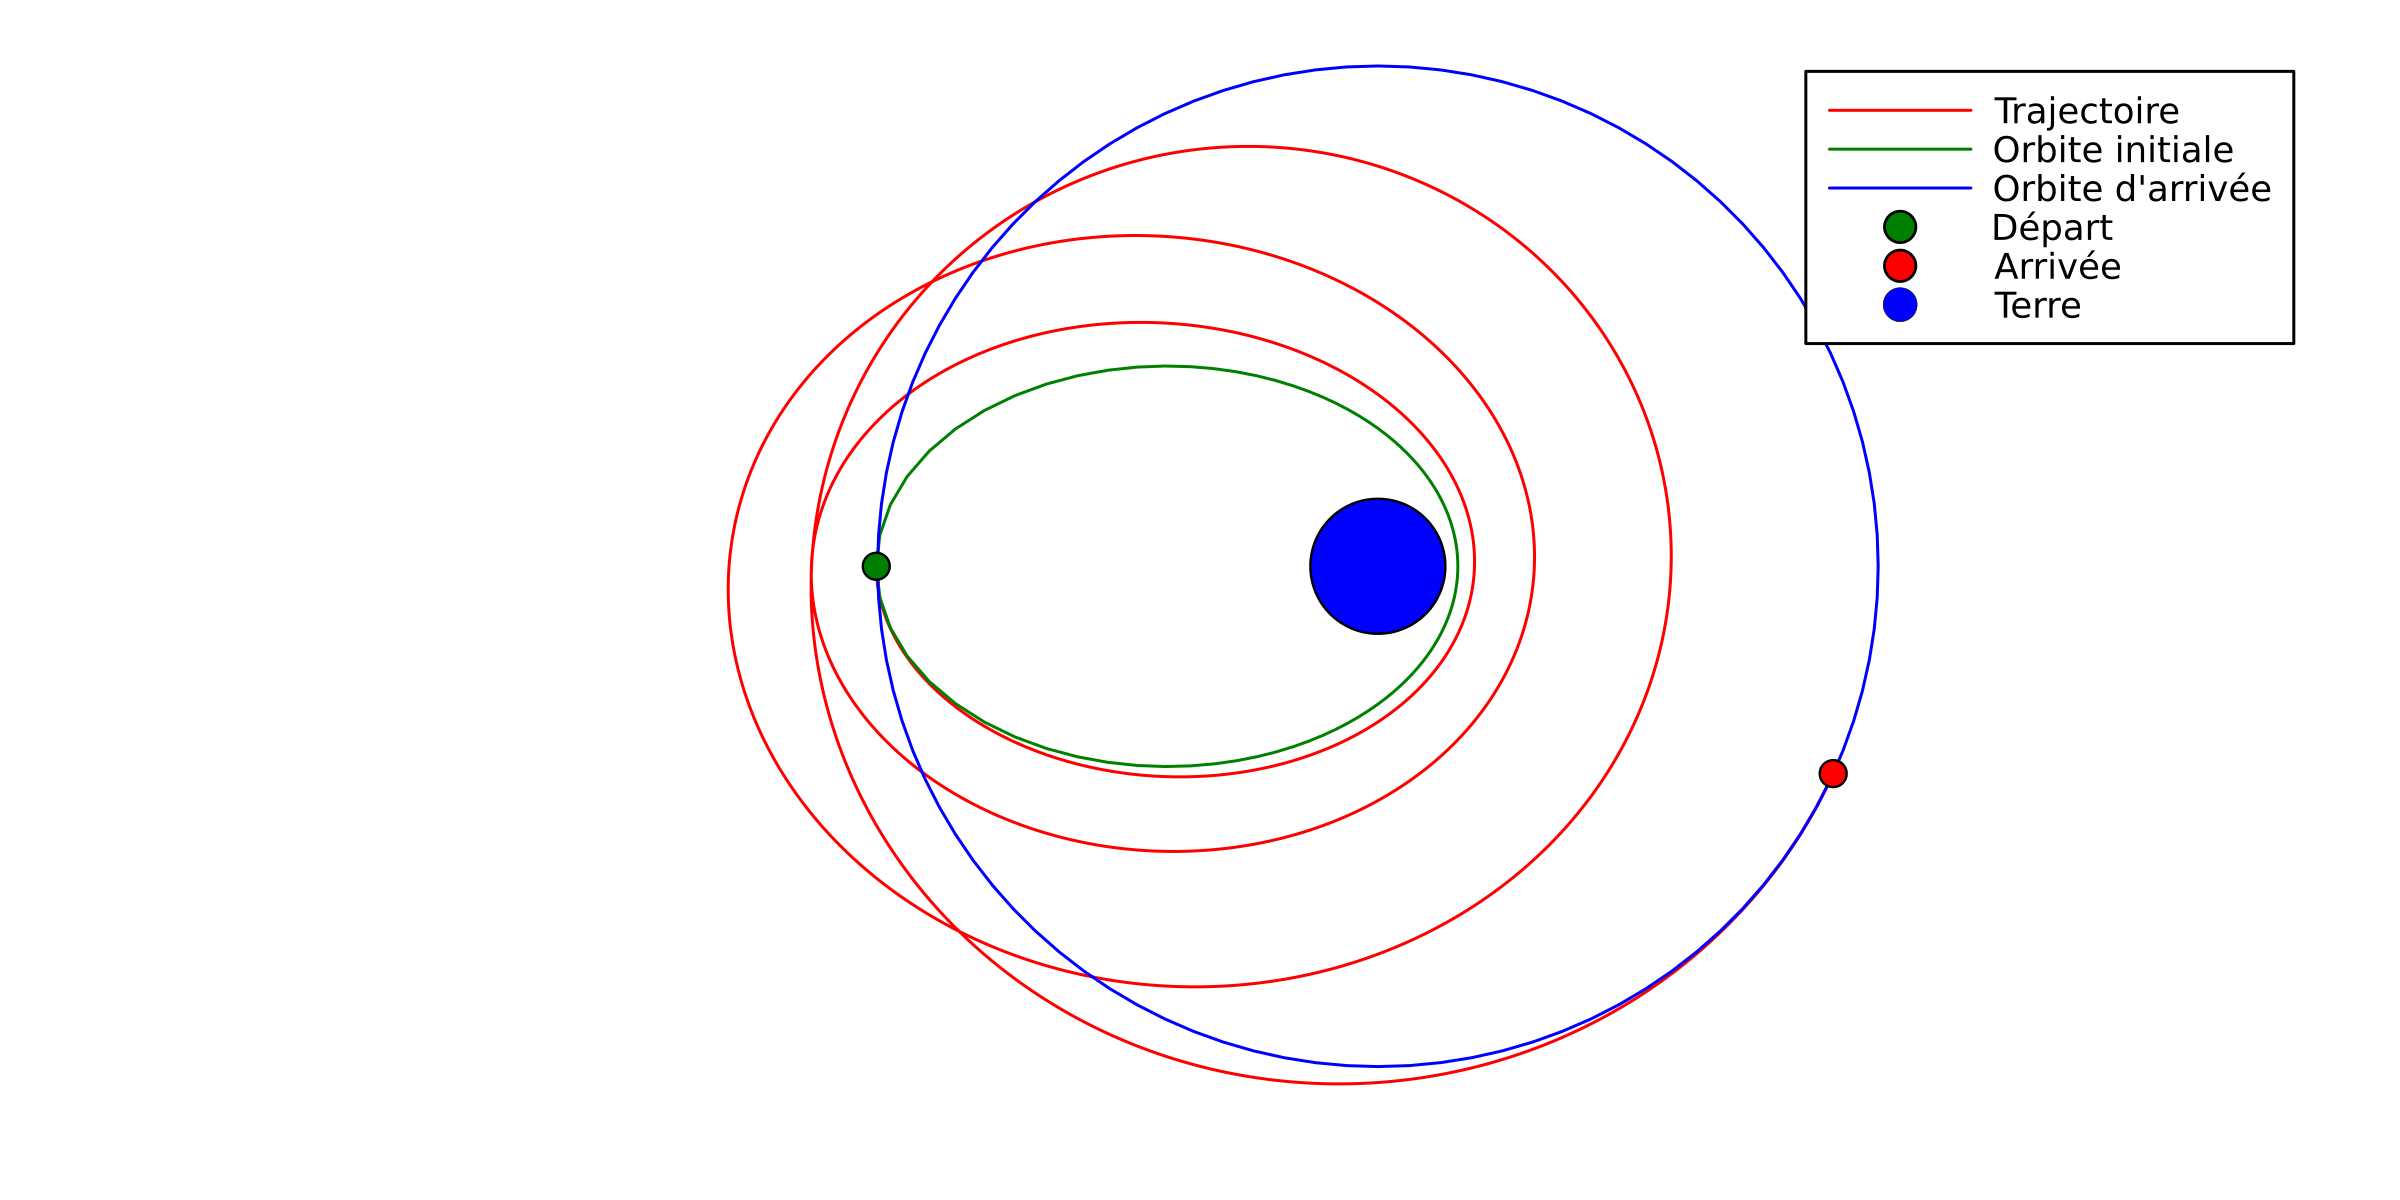

In [30]:
# Plots sol pour F_max = 20N
i = 11
γ_max = γ_max_span[i]
plot_solution(p0_sols[:, i], tf_sols[i])

### Animation

Juste pour s'amuser

In [31]:
include("space.jl"); using .Space

In [ ]:
# solution choice
i = 11
γ_max = γ_max_span[i] # γ_max must be updated for the use of the flow

# animation
# nFrame = 100; d = 30; fps = floor(Int, nFrame/d) => 2 minutes and 30 seconds of computation
nFrame = 100; d = 30; fps = floor(Int, nFrame/d)
Space.animation(p0_sols[:, i], tf_sols[i], f, γ_max, nFrame=nFrame, fps=fps)

Fps     = 3
NFrame  = 100
Vitesse = 0.3684871655899511
Durée totale de la mission = 90.45995748580926 h


<div style="width:90%;
            margin:10px;
            padding:8px;
            background-color:#afa;
            border:2px solid #bbffbb;
            border-radius:20px;
            font-weight:bold;
            font-size:1.5em;
            text-align:center;">
Transfert orbital à consommation minimale
</div>

On considère maintenant le problème du transfert d'un satellite d'une orbite initiale à une orbite géostationnaire à temps final fixé en cherchant à minimiser la consommation de carburant. Ce problème s'écrit comme un problème de contrôle optimal sous la forme

$$
\left\lbrace
\begin{array}{l}
    \displaystyle \min J(x, u) = \int_{0}^{t_f} \Vert u(t)\Vert \mathrm{d}t \\[1.0em]
    \ \ \dot{x}_{1}(t) = ~ x_{3}(t)  \\[0.5em]
    \ \ \dot{x}_{2}(t) = ~ x_{4}(t)  \\[0.5em]
    \ \ \dot{x}_{3}(t) =  -\dfrac{\mu\, x_{1}(t)}{r^{3}(x(t))} + u_{1}(t)  \\[1em]
    \ \ \dot{x}_{4}(t) =  -\dfrac{\mu\, x_{2}(t)}{r^{3}(x(t))} + u_{2}(t), ~~ ||u(t)|| \leq \gamma_\mathrm{max}, ~~ t \in [0,t_f] ~~ \text{p.p.}, ~~ u(t) = (u_1(t),u_2(t)),  \\[1.5em]
    \ \ x_{1}(0)=x_{0,1}, ~~ x_{2}(0)=x_{0,2}, ~~ x_{3}(0)=x_{0,3}, ~~ x_{4}(0)=x_{0,4}, \\[1em]
    \ \ r(x(t_f)) = r_{f}, ~~ x_{3}(t_f)=-\sqrt{\dfrac{\mu}{r_{f}^{3}}}x_{2}(t_f), ~~ x_{4}           (t_f)= \sqrt{\dfrac{\mu}{r_{f}^{3}}}x_{1}(t_f). \\
\end{array}
\right.
$$

Toutes les constantes sont identiques au problème précédent. On considéra le problème avec $F_\mathrm{max} = 100$ et on prendre comme temps final : $t_f = 1.5 T^{100}_{\min}$, où $T^{100}_{\min}$ correspond au temps minimal solution du problème précédent pour $F_\mathrm{max} = 100$.

**Remarques importantes.** 

* On ne considèrera que des extrémales normales, c'est-à-dire $p^0 = -1$.
* Le problème a de la structure, le contrôle optimal est composé d'arcs où la poussée est nulle $u(t) = 0$ et où la poussée est maximale $\Vert u(t)\Vert = \gamma_\mathrm{max}$.
* Vous devrez dans un premier temps résoudre le problème avec le coût suivant ce qui permet de le régulariser et ainsi d'utiliser une méthode de tir simple :

$$
\int_{0}^{t_f} \left( \Vert u(t)\Vert - \varepsilon \left( \ln(\Vert u(t)\Vert) + \ln(\gamma_\mathrm{max}-\Vert u(t)\Vert) \right) \right) \mathrm{d}t.
$$

✏️ **_Question 8:_** Résoudre via du tir simple le problème régularisé pour différentes valeurs de $\varepsilon$ suffisamment petites pour déterminer la structure optimale, en commençant avec $\varepsilon$ suffisamment grand pour faire converger la méthode de tir plus facilement.

**Calcul du contôle maximisant**

On veut maximiser la fonction suivante:
$$
    \text{max}_{||u|| \leq \gamma_{max}} \text{ } p_{3}u_{1} + p_{4}u_{2} - ||u|| + \epsilon \text{ln} (||u||) + \epsilon \text{ln} (\gamma_{max} - ||u||)
$$
On reduit la dimension en recherchant $ u = \rho \frac{p_u}{||p_u||} $ où $p_u = \begin{pmatrix} p3 \\ p4 \end{pmatrix} $ pour $\rho \in [0; \gamma_{max}]$

On maximise la fonction $\Phi$ de la variable réelle, strictement concave sur l'intervalle considéré : 
$$
    \Phi(\rho) = \rho||p_u|| - \rho + \epsilon \text{ln} (\rho) + \epsilon \text{ln} (\gamma_{max} - \rho) \\

    = \rho(||p_u|| - 1) + \epsilon \text{ln} (\rho(\gamma_{max} - \rho))
$$

Ce qui à la CN1 (qui est suffisant dans ce cas par stricte concavité) : 

$$
    \frac{1}{\rho} - \frac{1}{\gamma_{max} - \rho} = -\frac{||p_u|| - 1}{\epsilon}
$$

In [ ]:
### NE FONCTIONNE PAS ###

γ_max  = F_max*3600^2/(2000*10^3)

ϵ = 1
tf = 13
function r(x)
    return sqrt(x[1]^2 + x[2]^2)
end

# pseudo-Hamiltonien problème de Lagrange
# On suppose p° = -1
function H(x, p, u)
    # H(x, p, u) = < p | f(x,u) >
    h = p[1]*x[3] + p[2]*x[4] + p[3]*(u[1] - μ*x[1]/(r(x)^3)) + p[4]*(u[2] - μ*x[2]/(r(x)^3)) - (norm(u, 2) - ϵ*(log(norm(u, 2)) - log(γ_max - norm(u, 2))))
    return h
end

# pseudo système hamiltonien
function Hv(x, p, u)
    n     = size(x, 1)
    # ̇x = ∂H/∂p
    dx    = zeros(eltype(x), n)
    dx[1] = x[3]
    dx[2] = x[4]
    dx[3] = -μ*x[1]/(r(x)^3) + u[1]
    dx[4] = -μ*x[2]/(r(x)^3) + u[2]
    # ̇p = -∂H/∂x
    dp    = zeros(eltype(x), n)
    dp[1] = μ*p[3]*((1/(r(x)^3)) - ((3*x[1]*x[1])/(r(x)^5))) - 3*μ*p[4]*(x[1]*x[2]/(r(x)^5))
    dp[2] = μ*p[4]*((1/(r(x)^3)) - ((3*x[2]*x[2])/(r(x)^5))) - 3*μ*p[3]*(x[1]*x[2]/(r(x)^5))
    dp[3] = -p[1]
    dp[4] = -p[2]

    return dx, dp
end

# Contrôle maximisant
function control_lagrange(p)
    pu = [ p[3] ; p[4] ]
    u    = zeros(eltype(p),2)
    
    # Résolution analytique d'un polynôme de degré 2
    m = -(norm(pu) - 1)/ϵ
    ρ_star = (-(2 - γ_max)) + sqrt((2 - γ_max)^2 + 4*m*γ_max)/(2*m)

    u = ρ_star * pu / norm(pu)
    return u
end

function shoot_lagrange(p0, tf)
    x_tf, p_tf = f(t0, x0, p0, tf)

    s = zeros(eltype(p0), 5)

    # c(x(tf)) 
    r_tf = sqrt(x_tf[1]^2 + x_tf[2]^2)
    s[1] = r_tf - rf 
    s[2] = x_tf[3] + α*x_tf[2]
    s[3] = x_tf[4] - α*x_tf[1]

    # Condition de transversalité
    s[4] = x_tf[2]*(p_tf[1] + α*p_tf[4]) - x_tf[1]*(p_tf[2] - α*p_tf[3])

    # H(z(tf,x0,p0),u(z(tf,x0,p0))) + p°
    u_tf = control_lagrange(p_tf)
    H_tf = H(x_tf, p_tf, u_tf)
    s[5] = H_tf - 1 # p° = -1
    
    return s
end

# Itéré initial
y_guess = [1.0323e-4, 4.915e-5, 3.568e-4, -1.554e-4, 13.4]   # pour F_max = 100N

# Jacobienne de la fonction de tir
foo_lagrange(p0)  = shoot(p0, tf)
jfoo_lagrange(p0) = ForwardDiff.jacobian(foo, p0)

# Résolution de shoot(p0, tf) = 0
nl_sol = nlsolve(foo_lagrange, jfoo_lagrange, y_guess; xtol=1e-8, method=:trust_region, show_trace=true);

# On récupère la solution si convergence
if converged(nl_sol)
    p0_sol= nl_sol.zero[1:4]
    println("\nFinal solution:\n", nl_sol.zero)
else
    error("Not converged")
end

plot_solution(p0_sol, tf)


✏️ **_Question 9:_** Résoudre via du tir multiple le problème de transfert orbital à consommation minimale. Vous utilisez la structure obtenue précédemment et vous donnerez au solveur une bonne condition initiale à l'aide de la question précédente.